In [1]:
import tensorflow
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import time
import os
import pydot
import graphviz
from keras.utils.vis_utils import plot_model

In [231]:
def plot_kps(keypoints,color):
    connections = (
        [0,1],
        [1,2],
        [3,4],
        [4,5],
        [2,6],
        [3,6],
        [6,7],
        [7,8],
        [8,9],
        [10,11],
        [11,12],
        [12,7],
        [13,7],
        [13,14],
        [14,15]
    )
    i = 0
    while(i < len(connections)):
        if (keypoints[ (connections[i][0]*2) ] >= 0) and (keypoints[ (connections[i][1]*2) ] >= 0):
            plt.plot( ( keypoints[ (connections[i][0]*2) ]*256 , keypoints[ (connections[i][1]*2) ]*256 ) , 
                     ( keypoints[ (connections[i][0]*2)+1 ]*256 , keypoints[ (connections[i][1]*2)+1 ]*256 ),
                     marker='o', color=color )
        i+=1


def data_preprocessing(data):
    data = np.array(data.iloc[500:600])
    X = []
    Y = []
    count = 0
    for row in data:
        img = cv2.imread('./singleImages/' + row[1])/255.0
        shape = [img.shape[1],img.shape[0]]
        img = cv2.resize(img, (100,100))
        X.append(img)
        y = row[2:]
        y = np.array(y).astype('float32').reshape(16,2)
        heatmaps = []
        for j in range(0, len(y)):
            y[j][0]/=shape[0]
            y[j][1]/=shape[1]
            heatmap = np.zeros((100,100))
#         some values sneak through that are somehow over 1 pixel off?
            heatmap[int(y[j][1]*100)-2, int(y[j][0]*100)-2] = 1
            heatmap = cv2.GaussianBlur(heatmap,(61,61),10,cv2.BORDER_DEFAULT)
            heatmaps.append(heatmap)
        heatmaps = np.array(heatmaps).astype('float32').swapaxes(1,2).swapaxes(2,0)
        Y.append(heatmaps)
        if count%100==0:
            print(count)
        count+=1
    X = np.array(X).reshape(len(X),100,100,3).astype('float32')
    Y = np.array(Y).astype('float32')
    return train_test_split(X,Y, test_size=0.2, random_state=123)

In [232]:
data = pd.read_csv('./adjusted.csv')
x_train, x_test, y_train, y_test = data_preprocessing(data)

0


In [233]:
y_train.shape

(80, 100, 100, 16)

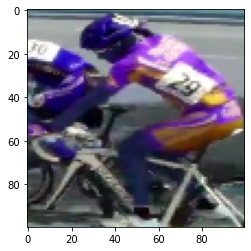

In [234]:
plt.imshow(x_train[0])

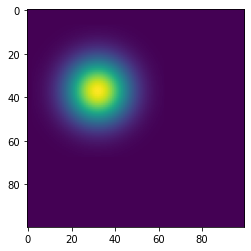

In [235]:
plt.imshow(y_train[0,:,:,14])

Model: "hourglass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_138 (Conv2D)         (None, 100, 100, 16)      64        
                                                                 
 conv2d_139 (Conv2D)         (None, 100, 100, 16)      2320      
                                                                 
 conv2d_140 (Conv2D)         (None, 100, 100, 16)      272       
                                                                 
Total params: 2,656
Trainable params: 2,656
Non-trainable params: 0
_________________________________________________________________


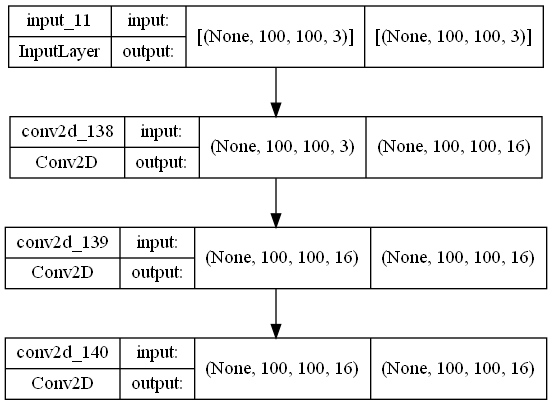

In [236]:
inputs = Input(shape=(100,100,3))

layer1 = Conv2D(filters=16,kernel_size=(1,1), strides=1, use_bias=True, activation='relu',padding='same')(inputs)
layer2 = Conv2D(filters=16,kernel_size=(3,3), strides=1, use_bias=True, activation='relu',padding='same')(layer1)
outputs = Conv2D(filters=16,kernel_size=(1,1), strides=1, use_bias=True, activation='relu',padding='same')(layer2)


model = Model(inputs = inputs, outputs = outputs, name = "hourglass")

model.summary()
plot_model(model, to_file='mymodel.png', show_shapes=True, show_layer_names=True)

In [237]:
model.compile( optimizer="adam" , loss="mse", metrics=['accuracy'])

In [238]:
model.fit( x_train, y_train, epochs=10, batch_size=10, validation_split=0.1 )
model.save('model2')

Epoch 1/10
8/8 [==============================] - 1s 54ms/step - loss: 0.0141 - accuracy: 0.0565 - val_loss: 0.0046 - val_accuracy: 0.0641
Epoch 2/10
8/8 [==============================] - 0s 43ms/step - loss: 0.0029 - accuracy: 0.0660 - val_loss: 0.0016 - val_accuracy: 0.0610
Epoch 3/10
8/8 [==============================] - 0s 45ms/step - loss: 0.0011 - accuracy: 0.0701 - val_loss: 4.5331e-04 - val_accuracy: 0.0768
Epoch 4/10
8/8 [==============================] - 0s 46ms/step - loss: 2.6006e-04 - accuracy: 0.0788 - val_loss: 1.0865e-04 - val_accuracy: 0.0673
Epoch 5/10
8/8 [==============================] - 0s 45ms/step - loss: 7.1953e-05 - accuracy: 0.0843 - val_loss: 4.4985e-05 - val_accuracy: 0.0685
Epoch 6/10
8/8 [==============================] - 0s 44ms/step - loss: 3.7249e-05 - accuracy: 0.0934 - val_loss: 2.4741e-05 - val_accuracy: 0.0928
Epoch 7/10
8/8 [==============================] - 0s 48ms/step - loss: 2.0442e-05 - accuracy: 0.1033 - val_loss: 1.8614e-05 - val_accuracy

In [239]:
model.evaluate(x_test,y_test)

1/1 [==============================] - 0s 36ms/step - loss: 8.9407e-06 - accuracy: 0.1004


[8.940724910644349e-06, 0.10037499666213989]

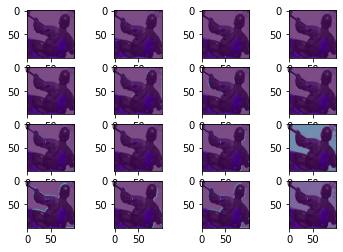

In [241]:
imgn = x_train[31]
img = imgn.reshape(1,100,100,3)
pred = model.predict(img)
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(pred[0,:,:,i])
    plt.imshow(imgn, cmap='jet', alpha=0.3)
# prediction = model.predict(x_test[0].reshape(1,256,256,3))
# plt.imshow(prediction[0,:,:,13])
# clearly not working, not sure whats broken yet

2931


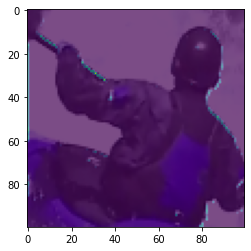

In [246]:
plt.subplot(1,1,1)
arg = np.argmax(pred[0,:,:,8])
print(arg)
plt.imshow(pred[0,:,:,8])
plt.imshow(imgn, cmap='jet', alpha=0.3)

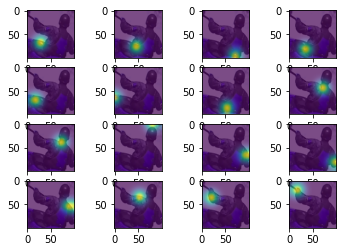

In [243]:
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(y_train[31,:,:,i])
    plt.imshow(x_train[31], cmap='jet', alpha=0.3)

In [34]:
model.weights[79]

<tf.Variable 'conv2d_43/bias:0' shape=(16,) dtype=float32, numpy=
array([-1.5824164e-05, -7.5987545e-03, -2.0570113e-05, -8.2333451e-03,
       -4.0941974e-03, -8.4167011e-03, -8.7461164e-03, -7.0462823e-03,
       -4.4283923e-03, -4.8813196e-03, -2.4675238e-03, -6.0169226e-03,
       -5.7866815e-03, -5.8339629e-03, -5.3059412e-03, -9.3638077e-03],
      dtype=float32)>

In [74]:
# p+=1
# input_image = x_test[p]
# im = input_image
# input_image = input_image.reshape(1,100,100,3)
# keypoints = model.predict(input_image)
# keypoints = np.squeeze(keypoints)
# plot_kps(y_test[p],'green')
# plot_kps(keypoints,'red')
# plt.imshow(im, cmap="gray")
# # only has good accuracy on training dataset so its overfitting

NameError: name 'p' is not defined